<table>
<tr>                                                                                   
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'>Meteo France 1996-2024<br>Analyse exploratoire des données</div>
     </th>
 </tr>
</table>


<table>
<tr>                                                                                   
     <th>
        <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/meteo_france_synop01.png" width="512">
     </th>
     <th>
         <a href="https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=90&id_rubrique=32">
             <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/meteo-france.jpg" width="512">
         </a> <br><br><br>       
         <a href="https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm">
             Observation météorologique historiques France (SYNOP) 2010-2024
         </a>                      
     </th>
 </tr>
</table>




# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Import libraries</div></b>

In [18]:
import pandas as pd, numpy as np, seaborn as sns, warnings, os, sys, time, copy as cp
from datetime import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects


import plotly.express as px
import plotly.graph_objs as go

font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
sns.set(font_scale=2)

os.chdir("C:/Users/etien/Documents/CCI/_HUB/cours/2024-2025/big_data/_git/MachineLearning/donnees/meteo France SYNOP")


In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Outils du document</div></b>

In [20]:
repertoireRacine  = '.'
nomProjet         = 'Meteo France 1996-2024-Analyse exploratoire des données'

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet);
controleExistenceRepertoire(repertoireDonnees);
controleExistenceRepertoire(repertoireImages);

In [21]:
def formatPct(pct, allvals):
    total = int(round(pct/100. * np.sum(allvals)))
    return "{:.2f}%\n({:d})".format(pct, total)   

In [22]:
def affichageDistribution(colonne,couleur,ax, nom=''):
    graph = sns.distplot(colonne, color=couleur, ax=ax)
    graph.set(ylabel=None)
    moyenne, mediane = float(colonne.mean()), \
                   float(colonne.median())
    
    ax.axvline(moyenne, color='g', linestyle='-', label=f"{nom:12s} mean   = {moyenne:0.4f}", lw=2)
    ax.axvline(mediane, color='b', linestyle='--', label=f"{nom:12s} median = {mediane:0.4f}", lw=2)
    graph.legend(loc="upper right")
    

In [23]:
def add_median_labels(ax, precision='.1f'):
    lines = ax.get_lines()
    # determine number of lines per box (this varies with/without fliers)
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    # iterate over median lines
    for median in lines[4:len(lines):lines_per_box]:
        # display median value at center of median line
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1]-median.get_xdata()[0]) == 0 else y
        text = ax.text(
                       x, 
                       y, 
                       f'{value:{precision}}', 
                       verticalalignment='center',
                       horizontalalignment='center', 
                       fontweight='bold', 
                       color='black',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
                      )
        # créer une bordure de couleur médiane autour du texte blanc pour le contraste 
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])  

In [24]:
def afficheDendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Classification Hiérarchique Ascendante')
        plt.xlabel('Villes ou (taille du cluster)')
        plt.ylabel('Distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

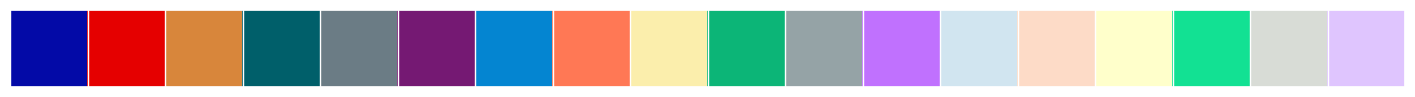

In [25]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
          ]
sns.palplot(sns.color_palette(palette))

# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Lecture des données</div></b>

In [26]:
donnees = pd.read_parquet("donnees_meteo.gzip")
#donnees.sample(5)
#donnees.set_index(['Nom', 'Latitude', 'Longitude', 'Altitude', 'Zone'],inplace=True)
donneesI = donnees.copy()
donnees[['VitesseVent','Temperature','Humidite','Pression','Visibilite','Precipitation']].head()
donneesI.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3478600 entries, ('Abbeville', 50.136, 1.834, 69, 'NO') to ('Bastia', 42.540667, 9.485167, 10, 'SE')
Data columns (total 18 columns):
 #   Column         Dtype         
---  ------         -----         
 0   DateHeure      datetime64[us]
 1   DirectionVent  float64       
 2   VitesseVent    float64       
 3   Temperature    float64       
 4   Humidite       float64       
 5   Visibilite     float64       
 6   Pression       float64       
 7   Precipitation  float64       
 8   Jour           int32         
 9   Semaine        UInt32        
 10  Mois           int32         
 11  Annee          int32         
 12  MoisJour       int32         
 13  AnneeMois      int32         
 14  AnneeSemaine   Int64         
 15  AnneeJour      int32         
 16  Heure          int32         
 17  JourNuit       object        
dtypes: Int64(1), UInt32(1), datetime64[us](1), float64(7), int32(7), object(1)
memory usage: 394.8+ MB


# <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Statistiques descriptives et analyse de données</div></b>

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Evolution de la température entre 1996-2024</div></b>

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Structuration des données</div></b>
<div style='padding:15px;color:#030aa7;font-size:100%;text-align: left;font-family: Georgia, serif'>Les données sont structurées dans un tableau ou matrice à n lignes et p colonnes. Chacune des n lignes représente un individu et chacune des p colonnes une variable. Pour une analyse en composantes principales, la variables sont uniquement quantitatives : la matrice est donc constituée de valeurs numériques.</div> <img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/acp_representation_variables.png" width="512">

In [27]:
donnees = donneesI.reset_index().pivot_table(index=['Nom', 'Latitude', 'Longitude', 'Altitude', 'Zone'],
                                 columns=['Semaine', 'JourNuit'],
                                 values=['Temperature','Humidite','Pression','VitesseVent'],  
                                 aggfunc = 'median',
                                 sort = False)

donnees.columns=[f'{column[0][0]}{column[1]:03d}{column[2][0]}' for column in donnees.columns]
donnees.sample(10)

,,,,,T001n,T001j,T002n,T002j,T003n,T003j,T004n,T004j,T005n,T005j,...,V049n,V049j,V050n,V050j,V051n,V051j,V052n,V052j,V053n,V053j
Nom,Latitude,Longitude,Altitude,Zone,,,,,,,,,,,,,,,,,,,,,
Montelimar,44.581167,4.733000,73,SE,5.00,7.00,4.00,6.55,4.30,6.70,4.2,6.20,4.6,6.90,...,3.1,3.60,3.0,3.60,3.1,3.50,3.00,3.5,2.00,2.25
Perpignan,42.737167,2.872833,42,SE,7.80,10.50,6.80,10.10,6.80,10.00,6.8,9.89,7.7,10.40,...,3.1,4.10,3.0,3.10,2.7,3.25,2.60,2.8,3.30,4.10
Brest,48.444167,-4.412000,94,NO,7.70,8.70,7.30,8.90,7.15,8.40,5.5,7.55,6.8,8.30,...,4.1,4.90,4.1,4.80,4.6,5.10,4.60,5.1,5.10,5.35
Poitiers,46.593833,0.314333,123,NO,5.75,7.30,4.70,6.70,4.40,6.40,3.0,5.60,4.7,6.75,...,4.1,4.10,3.2,4.10,3.1,4.10,3.80,4.4,4.10,4.10
Montpellier,43.577000,3.963167,2,SE,6.60,9.80,4.95,9.00,5.60,9.60,5.5,9.20,5.6,9.70,...,3.1,4.05,3.1,3.65,3.1,4.10,3.00,3.3,4.10,4.10
Nice,43.648833,7.209000,2,SE,7.30,10.40,7.10,10.30,6.60,10.20,7.4,10.80,7.2,11.20,...,5.1,4.10,5.1,4.10,5.1,4.10,5.10,4.1,4.50,4.05
Rennes,48.068833,-1.734000,36,NO,6.20,8.10,6.00,7.70,5.40,7.55,4.0,6.80,5.3,7.60,...,3.0,4.10,3.1,3.60,3.1,4.10,3.50,4.1,3.65,4.40
Reims,49.209667,4.155333,95,NE,5.00,6.90,3.50,5.15,1.85,4.00,0.8,3.45,5.3,7.10,...,2.6,3.10,2.6,3.10,3.4,3.80,3.95,4.1,3.70,3.65
Dijon,47.267833,5.088333,219,NE,2.95,4.75,1.40,3.50,1.10,3.20,0.7,2.70,1.9,4.20,...,3.1,3.60,3.0,3.10,2.2,2.90,3.10,3.2,3.00,3.25


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Centrage et réduction des données</div></b>
<table>
<tr>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/moyenne.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/ecart_type.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/centrage_reduction.png"></th>
</tr>
</table>

In [28]:
modelStd = StandardScaler()
modelStd.fit(donnees)
donnees[donnees.columns] = modelStd.transform(donnees)
donnees.head()

,,,,,T001n,T001j,T002n,T002j,T003n,T003j,T004n,T004j,T005n,T005j,...,V049n,V049j,V050n,V050j,V051n,V051j,V052n,V052j,V053n,V053j
Nom,Latitude,Longitude,Altitude,Zone,,,,,,,,,,,,,,,,,,,,,
Abbeville,50.136000,1.834000,69,NO,-0.175407,-0.416655,-0.020091,-0.468994,-0.096844,-0.490615,-0.274441,-0.609024,0.026788,-0.486730,...,0.373449,0.134276,0.493149,0.323874,0.471469,0.287968,0.297964,0.195369,0.055845,0.240632
Lille,50.570000,3.097500,47,NE,-0.495915,-0.721582,-0.296400,-0.681966,-0.311146,-0.784145,-0.501666,-0.801260,-0.349798,-0.663341,...,0.373449,0.607054,0.351526,0.398820,0.471469,0.650083,0.454395,0.759105,0.055845,0.175005
Pte De La Hague,49.725167,-1.939833,6,NO,1.656067,0.886847,1.722781,0.894025,1.660433,0.767372,1.646646,0.775080,1.746998,0.705391,...,3.463403,3.646346,3.396403,3.471610,3.480207,3.257313,3.864593,3.703059,3.345596,2.931332
Caen,49.180000,-0.456167,67,NO,0.236674,-0.137333,0.405000,0.127327,0.331760,-0.029353,0.138696,-0.070761,0.143019,-0.089357,...,0.440622,0.471975,0.493149,0.698605,0.681381,0.794929,0.923688,0.759105,0.665058,0.568766
Rouen,49.383000,1.181667,151,NO,-0.312768,-0.672701,-0.232636,-0.639372,-0.268286,-0.679313,-0.584294,-0.685919,-0.438133,-0.641265,...,0.373449,0.134276,0.351526,0.323874,0.471469,0.577660,0.297964,0.696467,0.055845,0.568766


## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Analyse en composantes principales</div></b>

<table>
<tr>
<th><div style='padding:15px;color:#030aa7;font-size:120%;text-align: center;font-family: Georgia, serif'>Quelle est la meilleure représentation simplifiée ?</div></th>
<th><div style='padding:15px;color:#030aa7;font-size:120%;text-align: center;font-family: Georgia, serif'>Recherche du meilleur axe de projection</div></th>
</tr>    
<tr>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/acp_analogie_photo.png" width="512"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/acp_projection_axe.png" width="512"></th>
</tr>
</table>    
<div style='padding:15px;color:#030aa7;font-size:120%;text-align: left;font-family: Georgia, serif'>A l'évidence, c'est la vue de profil. La raison est que l'image projetée du chameau dans ce plan est plus proche de l'image initiale dans le sens ou la variance des points servant à sa représentation est plus grande et donc restitue mieux la variance des points d'origine.</div>
<table>
<tr>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/axe_variance_max.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/MachineLearning/refs/heads/master/images/max_dist.png"></th>
</tr>
</table>

In [29]:
modelPCA = PCA(svd_solver='full')
modelPCA.fit(donnees)

PCA(svd_solver='full')

In [30]:
modelPCA.explained_variance_ratio_.cumsum()*100

array([ 42.88932149,  70.34546701,  87.18536838,  92.53912601,
        94.73093192,  96.44880597,  97.06649556,  97.54064481,
        97.91877222,  98.22224891,  98.43103507,  98.62337313,
        98.80276226,  98.93652191,  99.04693721,  99.14390984,
        99.23055826,  99.30465928,  99.37581952,  99.43931391,
        99.49524212,  99.54710872,  99.593959  ,  99.63930648,
        99.67857318,  99.71283346,  99.74459933,  99.77409913,
        99.80280786,  99.82819969,  99.85137663,  99.87182971,
        99.89051778,  99.90858118,  99.92603964,  99.94131291,
        99.95542462,  99.96889544,  99.98072718,  99.99046459,
       100.        , 100.        ])

In [31]:
modelPCA.explained_variance_*100

array([1.86286107e+04, 1.19253424e+04, 7.31426740e+03, 2.32535893e+03,
       9.51992184e+02, 7.46143930e+02, 2.68288203e+02, 2.05942680e+02,
       1.64236412e+02, 1.31812511e+02, 9.06844858e+01, 8.35403942e+01,
       7.79161378e+01, 5.80973594e+01, 4.79579431e+01, 4.21192355e+01,
       3.76349997e+01, 3.21851484e+01, 3.09078427e+01, 2.75782457e+01,
       2.42919390e+01, 2.25278148e+01, 2.03490217e+01, 1.96962907e+01,
       1.70551520e+01, 1.48806632e+01, 1.37972352e+01, 1.28129862e+01,
       1.24693908e+01, 1.10287236e+01, 1.00667082e+01, 8.88361906e+00,
       8.11700531e+00, 7.84568189e+00, 7.58293473e+00, 6.63381328e+00,
       6.12929993e+00, 5.85093384e+00, 5.13901643e+00, 4.22936146e+00,
       4.14162421e+00, 3.67384567e-27])

In [32]:
modelPCA.n_components_

42

In [33]:
inertie = pd.DataFrame(modelPCA.explained_variance_ratio_,columns=['Inertie']) 
inertie['Label'] = np.round(modelPCA.explained_variance_ratio_.cumsum()*100,2)
inertie['Dimension'] = range(1,len(modelPCA.explained_variance_)+1)
inertie['Inertie'] = np.round(inertie['Inertie']*100,2)
dim = modelPCA.n_components_
inertie = inertie[inertie['Dimension']<= dim]

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Choix du nombre des dimensions</div></b>
<div style='color:#030aa7;font-size:120%;text-align: left'>La qualité globale est mesurée par la part d'inertie expliquée. La valeur est choisie de sorte que cette part d'inertie expliquée soit supérieure à une valeur seuil fixée a priori par l'utilisateur.<br>C'est souvent le seul critère employé.<br><b>min 75%</b><br><br><b>95%</b></div>

In [34]:
sum(modelPCA.explained_variance_ratio_.cumsum()*100 <= 95) + 1

6

In [35]:
inertie[inertie.Dimension <= sum(modelPCA.explained_variance_ratio_.cumsum()*100 <= 95) + 1]

,Inertie,Label,Dimension
0,42.89,42.89,1
1,27.46,70.35,2
2,16.84,87.19,3
3,5.35,92.54,4
4,2.19,94.73,5
5,1.72,96.45,6


### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Pourcentage d'inertie(variance) associée à chaque dimension</div></b>

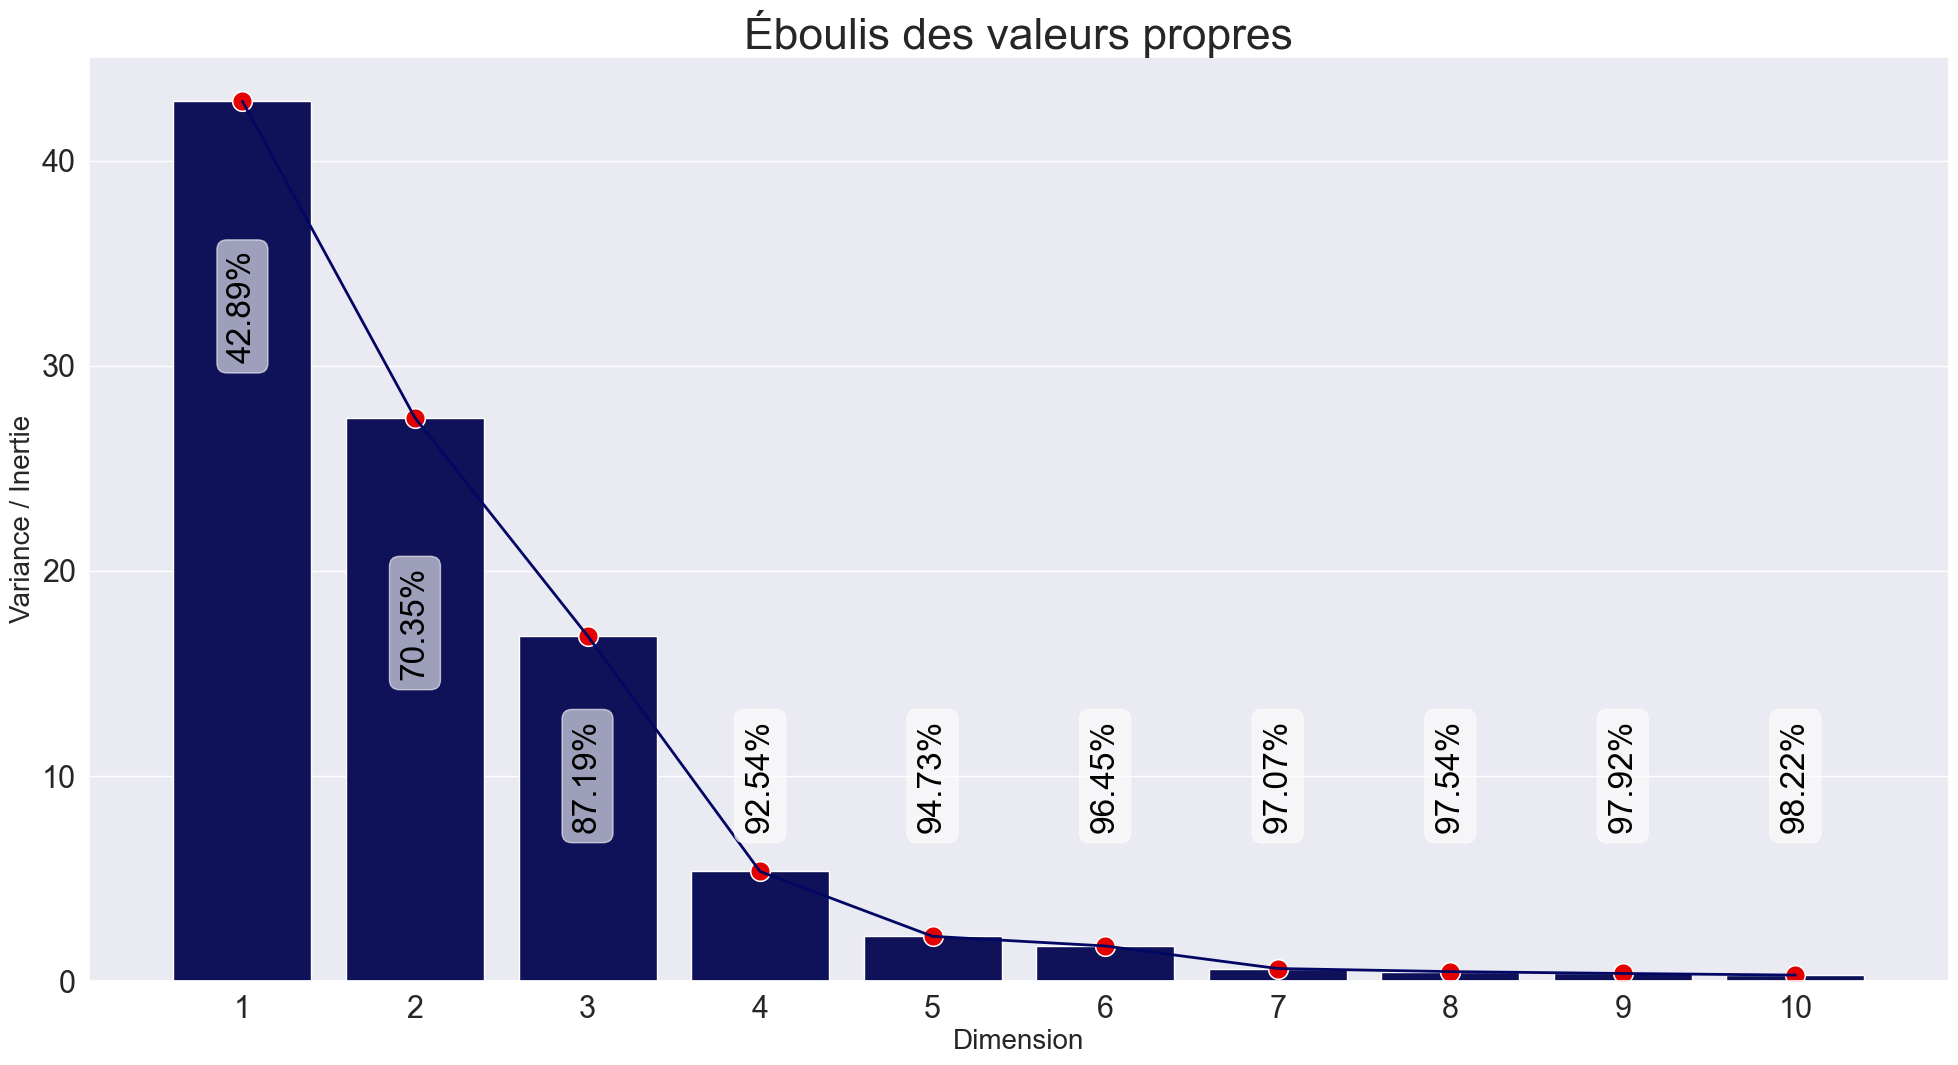

In [36]:
fig, ax = plt.subplots(figsize=(24,12));
graph = sns.barplot(x="Dimension",y='Inertie', data=inertie[inertie.Dimension <= 10], color="#030764", ax=ax)

for i,(nom,valeur) in enumerate(zip(inertie[inertie.Dimension <= 10].sort_values('Dimension').Label,inertie.sort_values('Dimension').Inertie)):
    # valeur = 0.1 if valeur - 0.1 < 0.1 else valeur - 0.1
    valeur = 10 if valeur - 10 < 10 else valeur - 10
    delta =  i 
    graph.text(
                delta ,
                valeur,
                f'{nom:0.2f}%',
                color='black',
                rotation='vertical',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
                verticalalignment='center',
                horizontalalignment='center',
               )
    
graph = sns.lineplot( x=inertie[inertie.Dimension <= 10].Dimension - 1,
                      y='Inertie',
                      data=inertie,
                      estimator = None, 
                      lw        = 2, 
                      ci        = None,
                      color     = "#030764",
                      ax    = ax);

sns.scatterplot(x=inertie[inertie.Dimension <= 10].Dimension - 1,
                y     = 'Inertie',
                data  = inertie,
                s     = 200,
                # ci    = None, 
                color = "#e50000",
                ax    = ax);    
    
ax.set_xlabel('Dimension', fontproperties=font1)
ax.set_ylabel('Variance / Inertie', fontproperties=font1)
ax.set_title('Éboulis des valeurs propres', fontproperties=fm.FontProperties(size=32))

sauvegarderImage('Choix du nombre des dimensions01--Temperatures')
sns.set(font_scale=2)

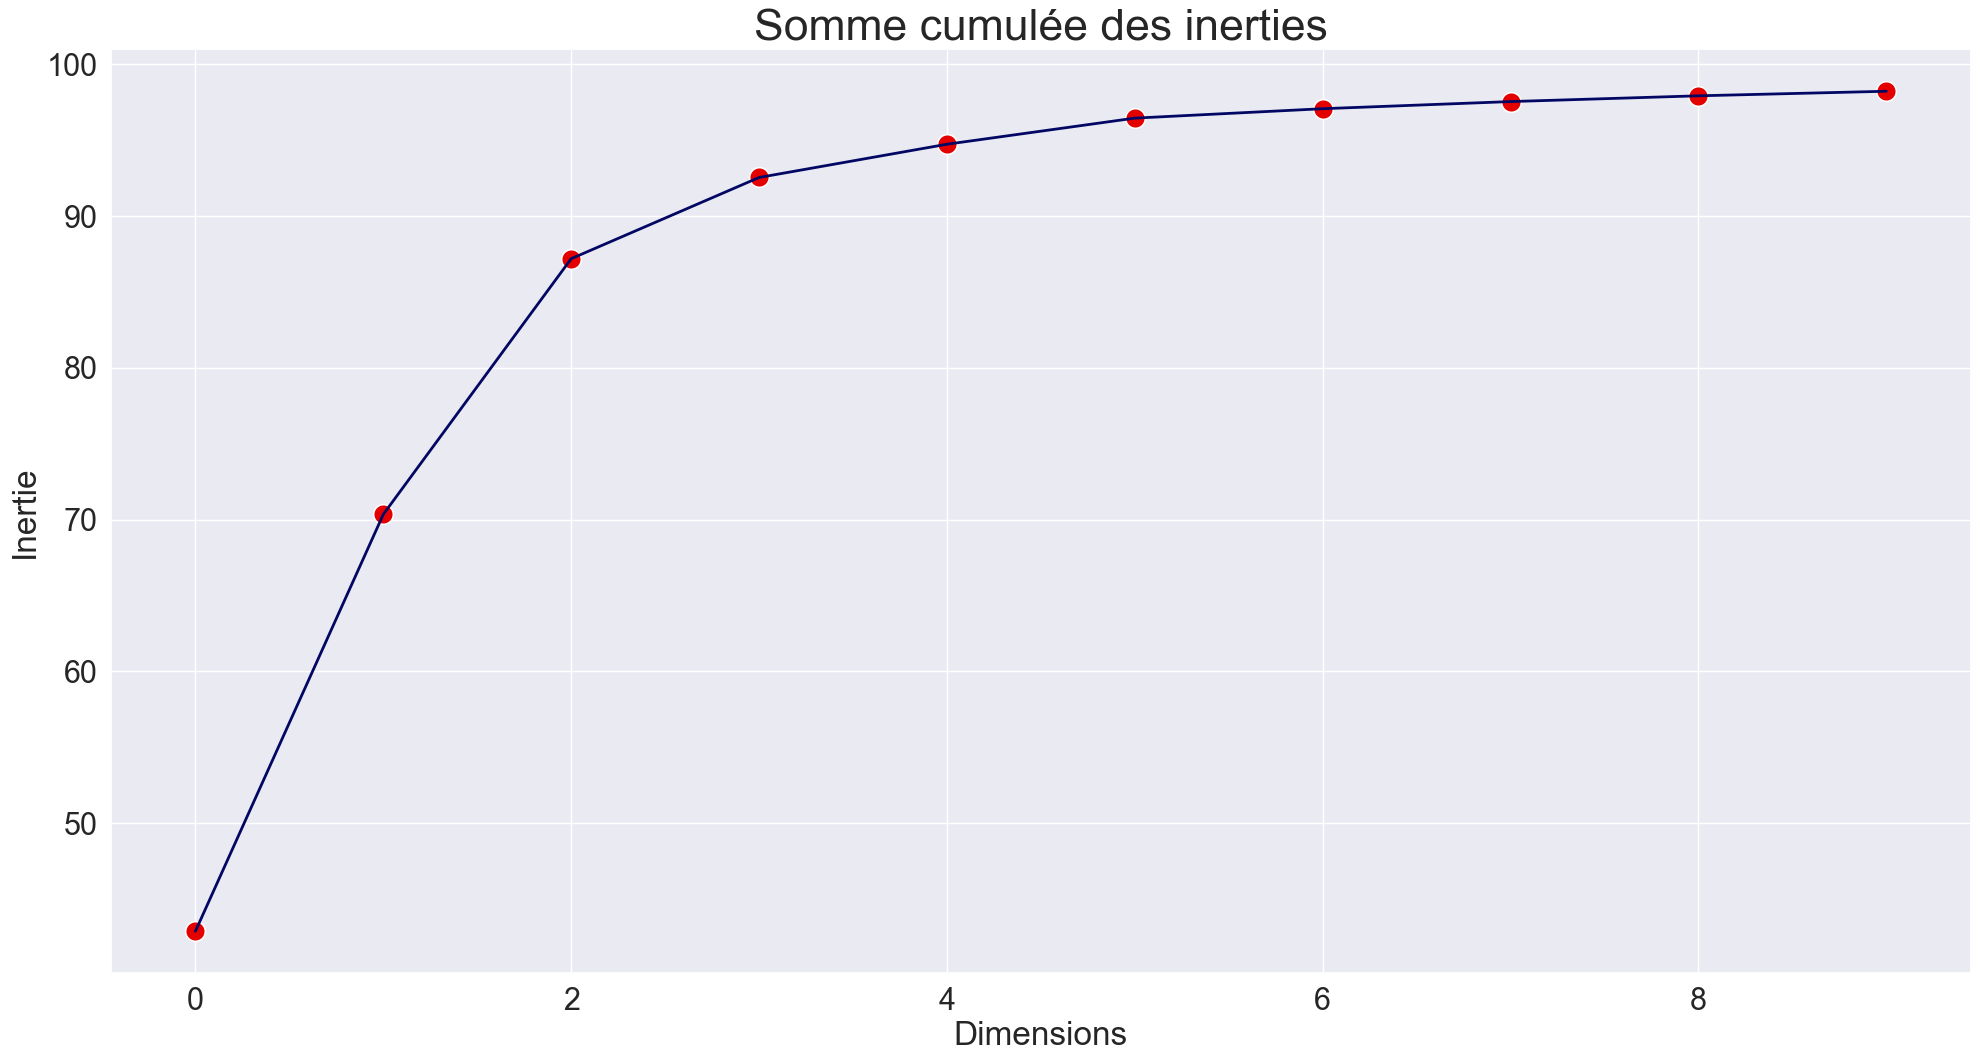

In [37]:
fig, ax = plt.subplots(figsize=(24,12));

sns.lineplot(x         = inertie[inertie.Dimension <= 10].Dimension-1,
             y         = 'Label',
             data      = inertie,
             estimator = None, 
             lw        = 2, 
             color     = "#030764",
             ax        = ax);
sns.scatterplot(x     = inertie[inertie.Dimension <= 10].Dimension-1,
                y     = 'Label',
                data  = inertie,
                s     = 200,
                color = "#e50000",
                ax    = ax);

ax.set_xlabel('Dimensions');
ax.set_ylabel('Inertie');
ax.set_title('Somme cumulée des inerties', fontproperties=fm.FontProperties(size=32));
sauvegarderImage('Choix du nombre des dimensions02--Temperatures')

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Règle de Kaiser</div></b>

<div style='color:#030aa7;font-size:120%;text-align: left'>On ne conserve que les valeurs propres supérieures à leur moyenne car les autres représentent moins de variabilité qu'une seule variable initiale.</div>

In [38]:
print(f'{100 / modelPCA.n_components_}')

2.380952380952381


In [39]:
inertie[inertie.Inertie >= (100 / modelPCA.n_components_)]

,Inertie,Label,Dimension
0,42.89,42.89,1
1,27.46,70.35,2
2,16.84,87.19,3
3,5.35,92.54,4


### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Transformation des données</div></b>

In [40]:
n_components = 4 
modelPCA = PCA(n_components=n_components).set_output(transform="pandas")
donneesACP = modelPCA.fit_transform(donnees)
donneesACP.columns = [f'Dimension{i:02d}' for i in range(1,n_components+1)]

<div style='padding:15px;color:#030aa7;font-size:120%;text-align: left;font-family: Georgia, serif'>Les nouvelles dimensions doivent être indépendantes deux à deux</div>

In [41]:
donneesACP.corr().style.format("{:0.1e}").background_gradient(cmap=plt.get_cmap('Blues'),axis=0)

,Dimension01,Dimension02,Dimension03,Dimension04
Dimension01,1.0e+00,4.7e-17,-1.6e-16,1.1e-17
Dimension02,4.7e-17,1.0e+00,5.9e-17,-2.9e-16
Dimension03,-1.6e-16,5.9e-17,1.0e+00,-5.9e-17
Dimension04,1.1e-17,-2.9e-16,-5.9e-17,1.0e+00


In [42]:
donneesACP.reset_index(inplace=True)

### <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:120%;text-align: left'>Représentation des individus</div></b>

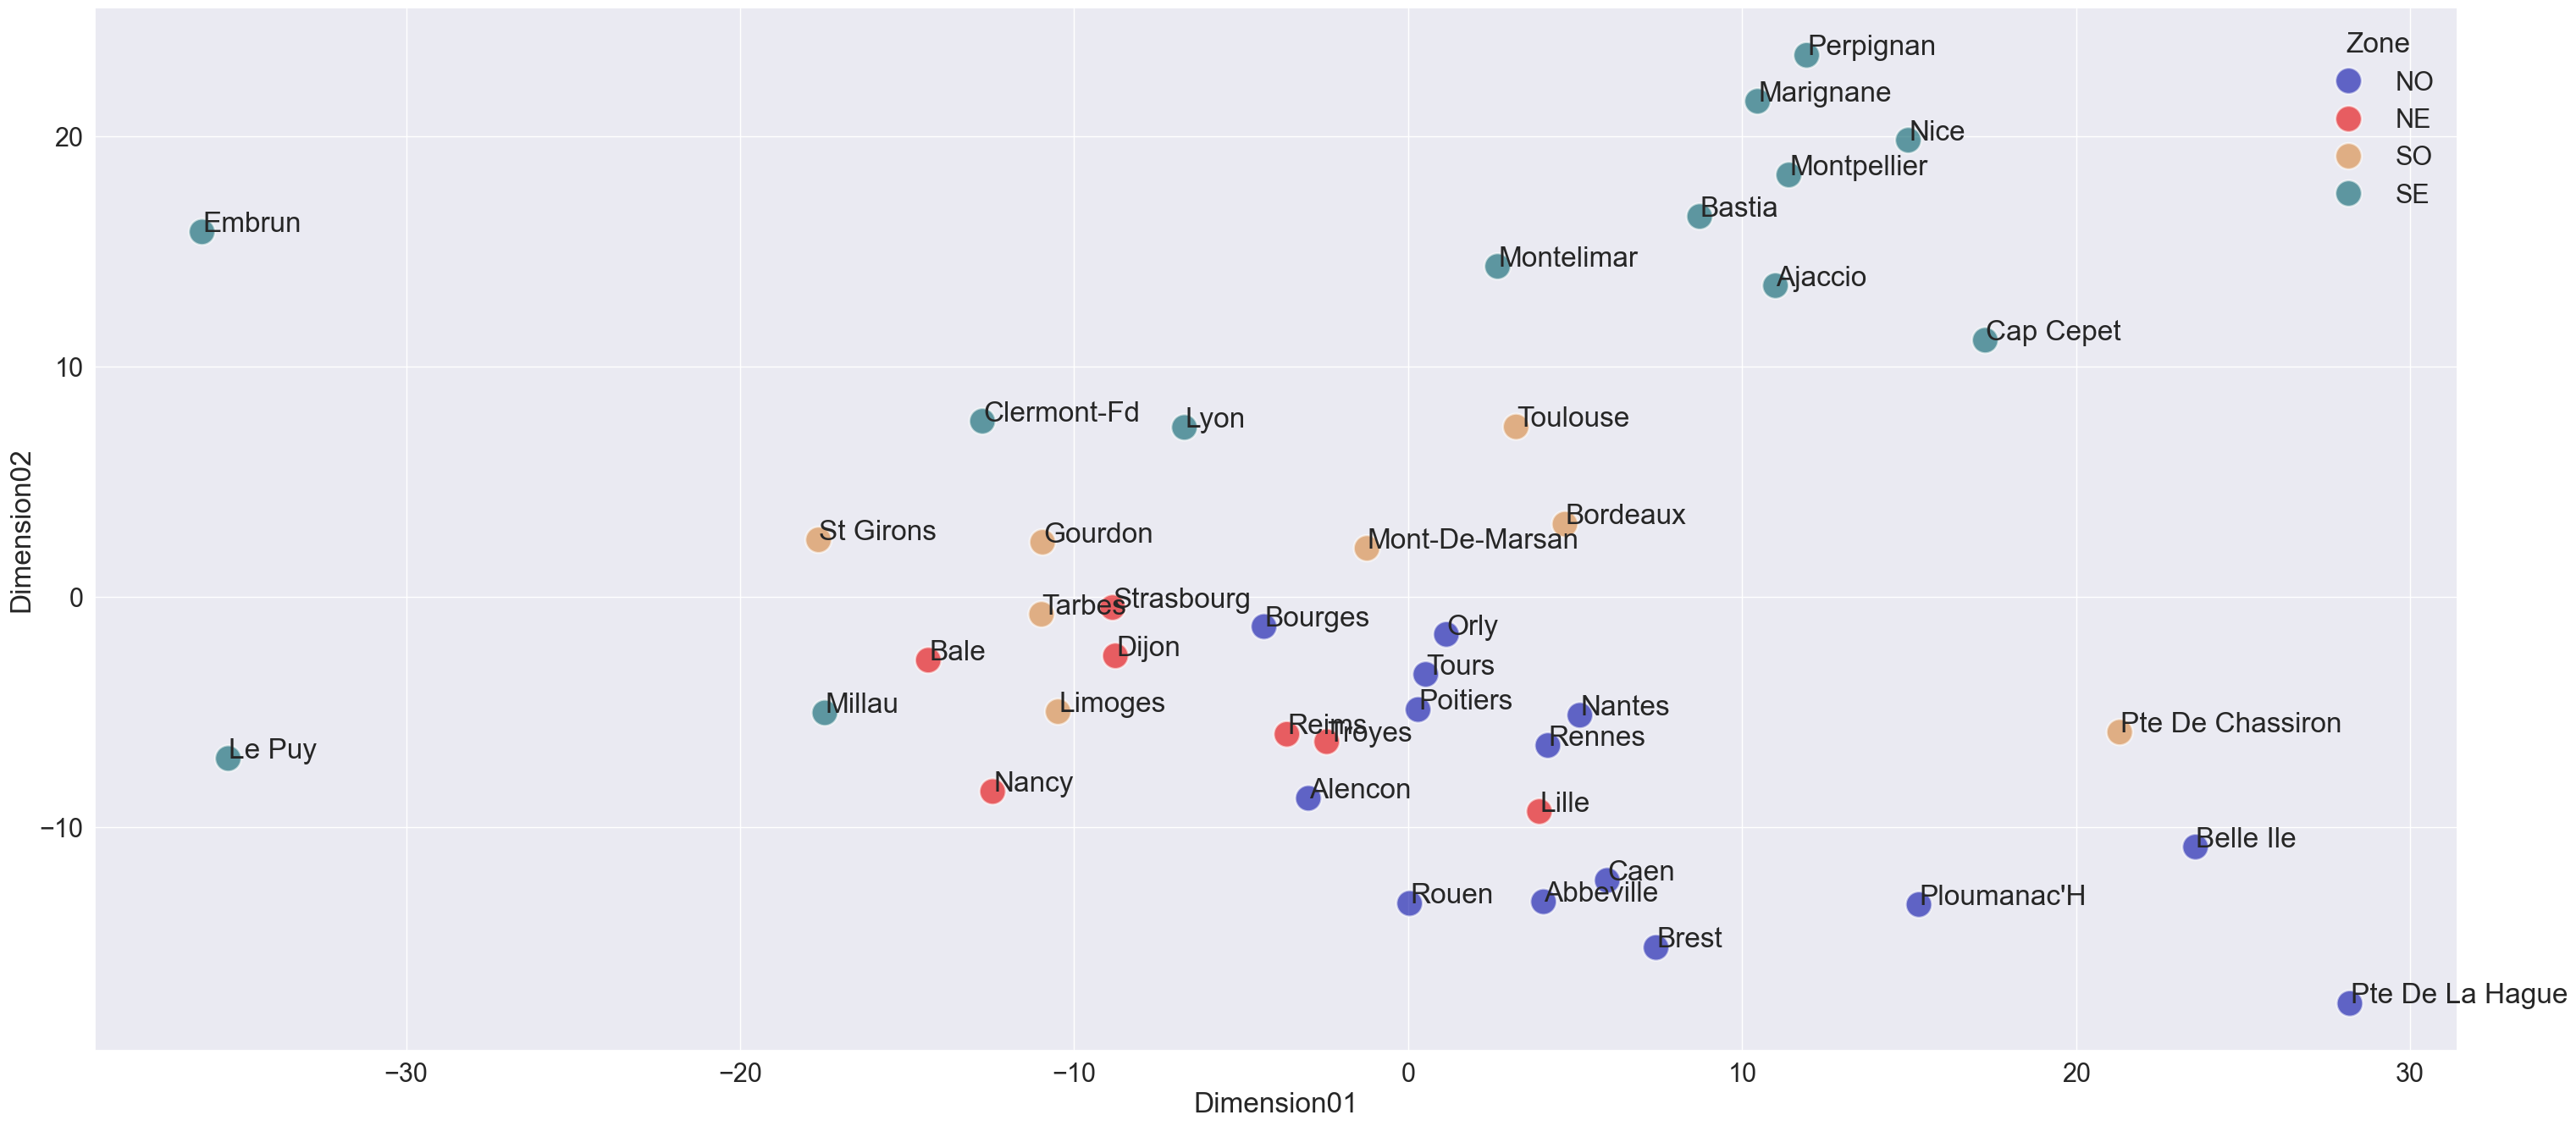

In [43]:
fig, ax = plt.subplots(figsize=(36,16));

sns.scatterplot(x       = 'Dimension01', 
                y       = 'Dimension02',
                # size    = 'Altitude', 
                hue     = 'Zone', 
                data    = donneesACP,
                s       = 500,
                palette = palette,
                alpha=0.6,
                ax=ax
                );

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.02, str(point['val']), fontproperties=font2, rotation=0)

label_point(donneesACP.Dimension01, donneesACP.Dimension02, donneesACP.Nom, ax)        
# sauvegarderImage('Influence des variables dans les nouvelles dimensions--Temperatures')

In [44]:
layout = go.Layout({"showlegend": False})

fig = px.scatter_3d(donneesACP, 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='Zone',
                    # size='Dimension04',
#                     symbol='Dimension04',
                    text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()